## Prediction for next few years


20:41:11 - cmdstanpy - INFO - Chain [1] start processing


Loading monthly data from: ../../Processed_Monthly/Monthly_Urbanization_Stats.csv
Loaded 246 monthly records (2015-08-20 → 2025-04-01)

Train/Test Split: 209 training, 37 testing records

🟢 Training Prophet...


20:41:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet → MAE: 284.457, RMSE: 366.252, R²: -1.108

🟡 Training ARIMA...
ARIMA(1,1,1) → MAE: 219.776, RMSE: 267.289, R²: -0.123

🟣 Training Random Forest...
Random Forest → MAE: 288.371, RMSE: 353.253, R²: -0.961

⚪ Running K-Means clustering...


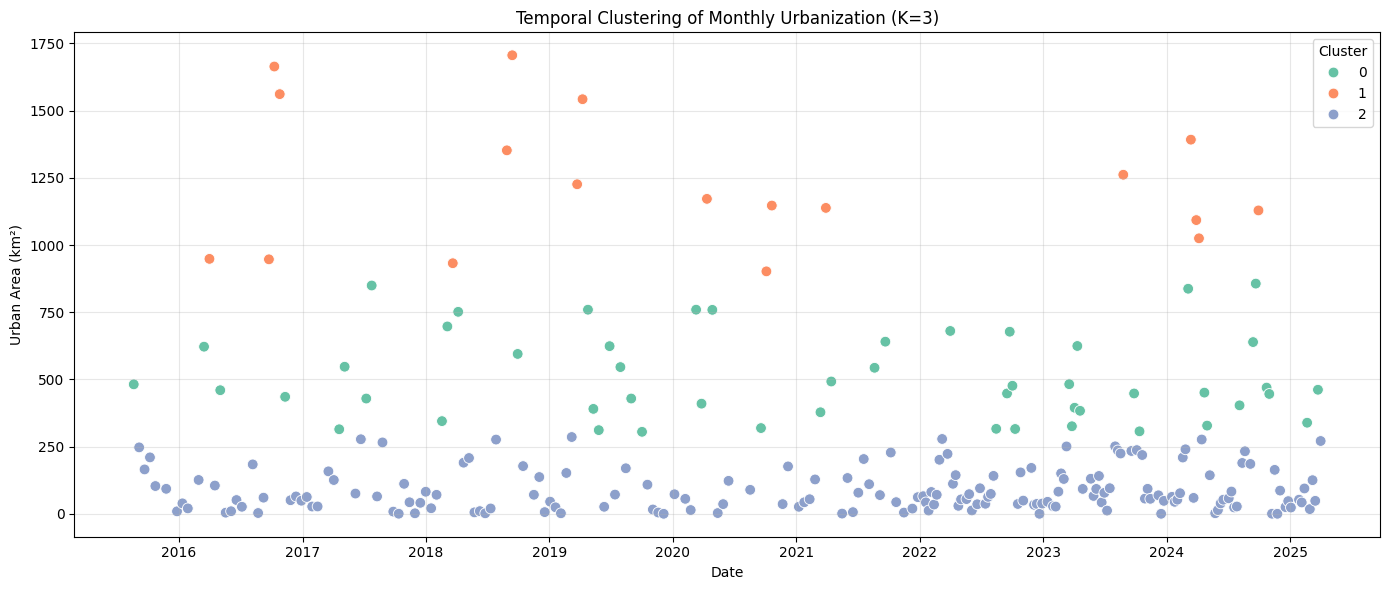


📊 Model Comparison Results (monthly data):
           Model         MAE        RMSE        R²
0        Prophet  284.456724  366.252386 -1.108359
1          ARIMA  219.775518  267.289382 -0.122916
2  Random Forest  288.371442  353.253153 -0.961353

🏆 Best Performing Model: ARIMA


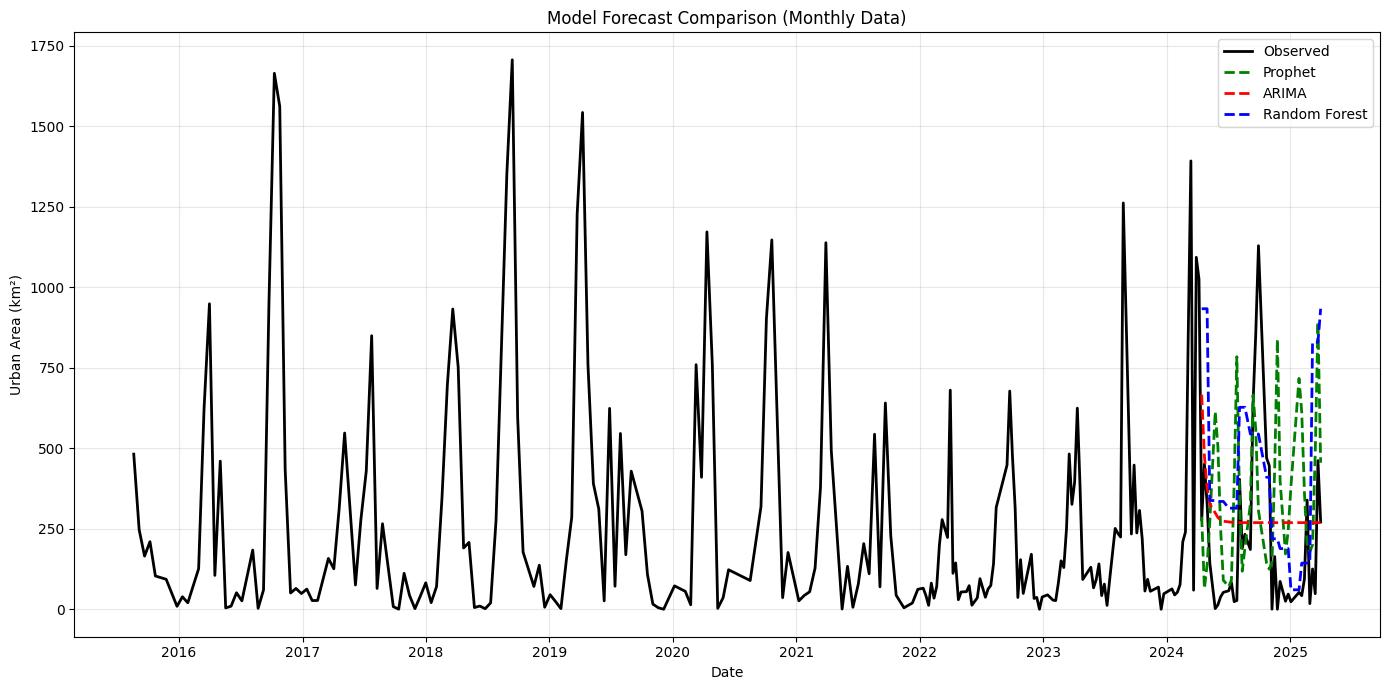


🔮 Generating future predictions...


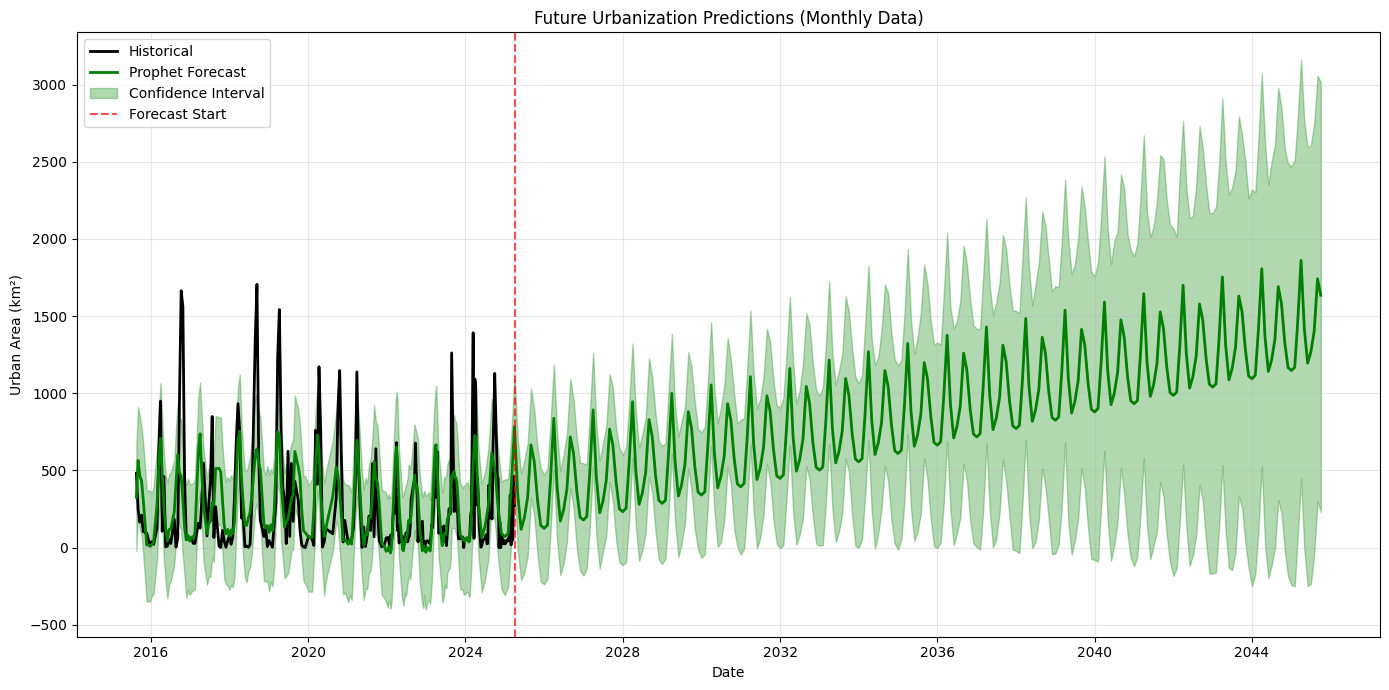


✅ Model comparison and prediction complete! Using monthly data with 246 records.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
BASE_DIR = "../.."  # Navigate from Code/anuradhapura_sat to root
MONTHLY_FILE = os.path.join(BASE_DIR, "Processed_Monthly/Monthly_Urbanization_Stats.csv")
YEARLY_FILE = os.path.join(BASE_DIR, "Processed/Urbanization_Stats.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "Model_Comparison")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# LOAD DATA WITH FALLBACK OPTIONS
def load_urbanization_data():
    """Load urbanization data with fallback options"""
    
    # Try monthly data first
    if os.path.exists(MONTHLY_FILE):
        print(f"Loading monthly data from: {MONTHLY_FILE}")
        df = pd.read_csv(MONTHLY_FILE, parse_dates=["Date"])
        df = df.sort_values("Date")
        print(f"Loaded {len(df)} monthly records ({df['Date'].min().date()} → {df['Date'].max().date()})")
        return df, "monthly"
    
    # Fallback to yearly data
    elif os.path.exists(YEARLY_FILE):
        print(f"Monthly data not found. Loading yearly data from: {YEARLY_FILE}")
        df = pd.read_csv(YEARLY_FILE)
        # Create approximate dates (mid-year) for yearly data
        df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-07-01')
        df = df.sort_values("Date")
        print(f"Loaded {len(df)} yearly records ({df['Year'].min()} → {df['Year'].max()})")
        return df, "yearly"
    
    else:
        raise FileNotFoundError(f"Neither monthly ({MONTHLY_FILE}) nor yearly ({YEARLY_FILE}) data files found!")

# Load data
df, data_type = load_urbanization_data()

# TRAIN/TEST SPLIT
train_size = int(len(df) * 0.85)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

y_train, y_test = train_df["Urban_Area_km2"], test_df["Urban_Area_km2"]
X_train_index, X_test_index = train_df["Date"], test_df["Date"]

print(f"\nTrain/Test Split: {len(train_df)} training, {len(test_df)} testing records")

# 1. PROPHET MODEL
print("\n🟢 Training Prophet...")
prophet_df = train_df[["Date", "Urban_Area_km2"]].rename(columns={"Date": "ds", "Urban_Area_km2": "y"})
model_prophet = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.3)
model_prophet.fit(prophet_df)

# Adjust frequency based on data type
freq = "MS" if data_type == "monthly" else "YS"
future = model_prophet.make_future_dataframe(periods=len(test_df), freq=freq)
forecast = model_prophet.predict(future)
prophet_forecast = forecast.tail(len(test_df))
prophet_pred = prophet_forecast["yhat"].values

# Metrics - Fixed RMSE calculation
prophet_mae = mean_absolute_error(y_test, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
prophet_r2 = r2_score(y_test, prophet_pred)

print(f"Prophet → MAE: {prophet_mae:.3f}, RMSE: {prophet_rmse:.3f}, R²: {prophet_r2:.3f}")

# 2. ARIMA MODEL (using statsmodels)
print("\n🟡 Training ARIMA...")

try:
    arima_model = ARIMA(y_train, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(y_test))
    
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    
    print(f"ARIMA(1,1,1) → MAE: {arima_mae:.3f}, RMSE: {arima_rmse:.3f}, R²: {arima_r2:.3f}")
    
except Exception as e:
    print(f"ARIMA model failed: {str(e)}")
    # Fallback to simple moving average
    window = min(12 if data_type == "monthly" else 3, len(y_train))
    arima_forecast = np.full(len(y_test), y_train.rolling(window=window).mean().iloc[-1])
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    print(f"Moving Average (fallback) → MAE: {arima_mae:.3f}, RMSE: {arima_rmse:.3f}, R²: {arima_r2:.3f}")

# 3. RANDOM FOREST MODEL
print("\n🟣 Training Random Forest...")
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

# Add additional features for better prediction
df["Quarter"] = df["Date"].dt.quarter
df["DayOfYear"] = df["Date"].dt.dayofyear

# Select features based on data type
if data_type == "monthly":
    feature_cols = ["Month", "Year", "Quarter"]
else:
    feature_cols = ["Year"]

X = df[feature_cols]
y = df["Urban_Area_km2"]

X_train_rf, X_test_rf = X.iloc[:train_size], X.iloc[train_size:]
y_train_rf, y_test_rf = y.iloc[:train_size], y.iloc[train_size:]

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_rf, y_train_rf)
rf_pred = rf.predict(X_test_rf)

rf_mae = mean_absolute_error(y_test_rf, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
rf_r2 = r2_score(y_test_rf, rf_pred)

print(f"Random Forest → MAE: {rf_mae:.3f}, RMSE: {rf_rmse:.3f}, R²: {rf_r2:.3f}")

# 4. K-MEANS CLUSTERING (Temporal Pattern Discovery)
print("\n⚪ Running K-Means clustering...")
X_scaled = StandardScaler().fit_transform(df[["Urban_Area_km2"]])
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(14,6))
sns.scatterplot(x="Date", y="Urban_Area_km2", hue="Cluster", palette="Set2", data=df, s=60)
plt.title(f"Temporal Clustering of {data_type.title()} Urbanization (K=3)")
plt.xlabel("Date"); plt.ylabel("Urban Area (km²)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"KMeans_Temporal_Clusters_{data_type}.png"), dpi=200)
plt.show()

df.to_csv(os.path.join(OUTPUT_DIR, f"KMeans_Clusters_{data_type}.csv"), index=False)

# 5. MODEL COMPARISON
results = pd.DataFrame({
    "Model": ["Prophet", "ARIMA", "Random Forest"],
    "MAE": [prophet_mae, arima_mae, rf_mae],
    "RMSE": [prophet_rmse, arima_rmse, rf_rmse],
    "R²": [prophet_r2, arima_r2, rf_r2]
})

print(f"\n📊 Model Comparison Results ({data_type} data):")
print(results)

# Choose best model by RMSE
best_model = results.loc[results["RMSE"].idxmin(), "Model"]
print(f"\n🏆 Best Performing Model: {best_model}")

# 6. VISUALIZE FORECASTS
plt.figure(figsize=(14,7))
plt.plot(df["Date"], df["Urban_Area_km2"], label="Observed", color="black", linewidth=2)
plt.plot(X_test_index, prophet_pred, "g--", label="Prophet", linewidth=2)
plt.plot(X_test_index, arima_forecast, "r--", label="ARIMA", linewidth=2)
plt.plot(X_test_index, rf_pred, "b--", label="Random Forest", linewidth=2)
plt.title(f"Model Forecast Comparison ({data_type.title()} Data)")
plt.xlabel("Date"); plt.ylabel("Urban Area (km²)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"Model_Forecast_Comparison_{data_type}.png"), dpi=200)
plt.show()

# 7. FUTURE PREDICTIONS
print(f"\n🔮 Generating future predictions...")
future_periods = 12 if data_type == "monthly" else 3
future_df = model_prophet.make_future_dataframe(periods=len(df) + future_periods, freq=freq)
future_forecast = model_prophet.predict(future_df)

plt.figure(figsize=(14,7))
plt.plot(df["Date"], df["Urban_Area_km2"], label="Historical", color="black", linewidth=2)
plt.plot(future_forecast["ds"], future_forecast["yhat"], "g-", label="Prophet Forecast", linewidth=2)
plt.fill_between(future_forecast["ds"], 
                future_forecast["yhat_lower"], 
                future_forecast["yhat_upper"], 
                alpha=0.3, color="green", label="Confidence Interval")
plt.axvline(x=df["Date"].max(), color="red", linestyle="--", alpha=0.7, label="Forecast Start")
plt.title(f"Future Urbanization Predictions ({data_type.title()} Data)")
plt.xlabel("Date"); plt.ylabel("Urban Area (km²)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"Future_Predictions_{data_type}.png"), dpi=200)
plt.show()

print(f"\n✅ Model comparison and prediction complete! Using {data_type} data with {len(df)} records.")

13:26:35 - cmdstanpy - INFO - Chain [1] start processing


13:26:35 - cmdstanpy - INFO - Chain [1] done processing


Forecast saved → Urbanization_Forecast_monthly_2026_2030.csv


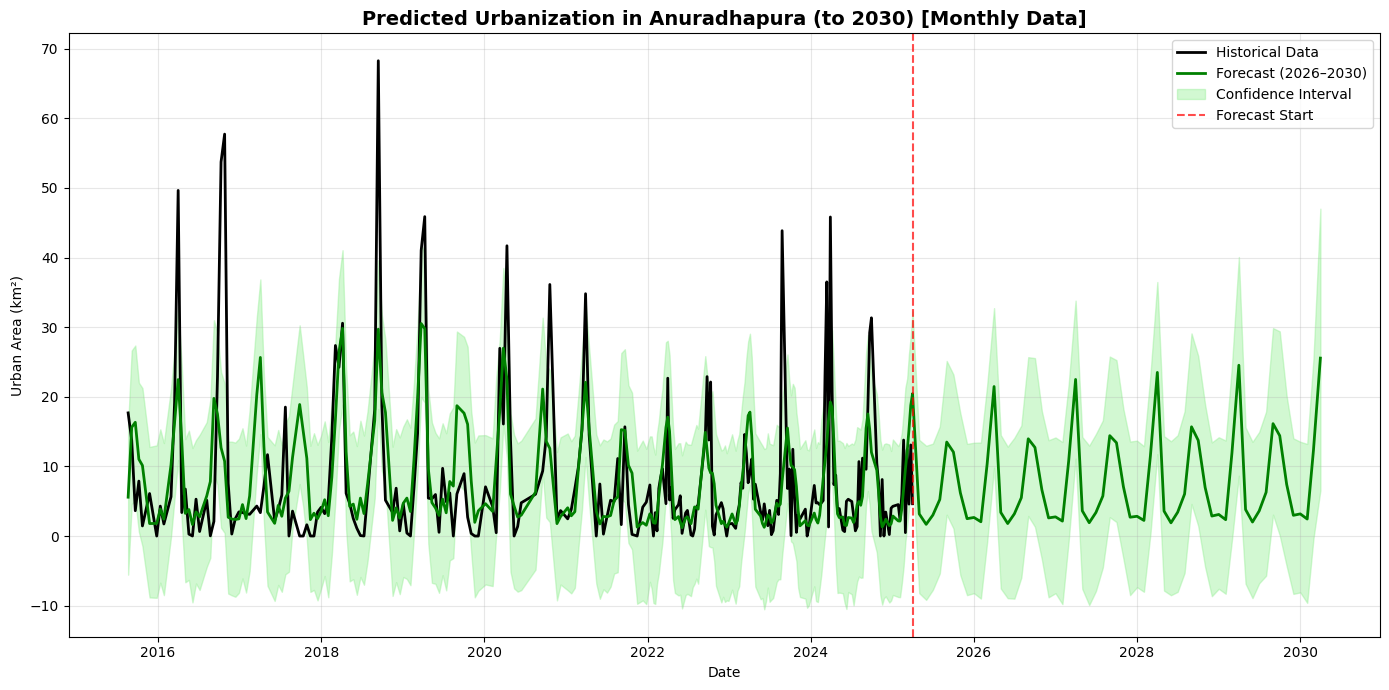


📈 Predicted Urban Area in 2030: 25.56 km²
➡️ Growth from 2025 to 2030: 20.92 km² (451.17% increase)


In [ ]:

#  FINAL MODEL BUILDING & LONG-TERM FORECAST (2026–2030)



# Retrain Prophet with full data
prophet_full_df = df[["Date", "Urban_Area_km2"]].rename(columns={"Date": "ds", "Urban_Area_km2": "y"})
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,
    seasonality_mode="multiplicative"
)
final_model.fit(prophet_full_df)

# Forecast 5 more years (2026–2030)
future_months = 60 if data_type == "monthly" else 5
future_full = final_model.make_future_dataframe(periods=future_months, freq=freq)
future_forecast = final_model.predict(future_full)

# Save results
forecast_output = future_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_output.to_csv(os.path.join(OUTPUT_DIR, f"Urbanization_Forecast_{data_type}_2026_2030.csv"), index=False)
print(f"Forecast saved → Urbanization_Forecast_{data_type}_2026_2030.csv")

# Plot forecast
plt.figure(figsize=(14,7))
plt.plot(prophet_full_df["ds"], prophet_full_df["y"], label="Historical Data", color="black", linewidth=2)
plt.plot(future_forecast["ds"], future_forecast["yhat"], "g-", linewidth=2, label="Forecast (2026–2030)")
plt.fill_between(
    future_forecast["ds"],
    future_forecast["yhat_lower"],
    future_forecast["yhat_upper"],
    color="lightgreen",
    alpha=0.4,
    label="Confidence Interval"
)
plt.axvline(x=prophet_full_df["ds"].max(), color="red", linestyle="--", alpha=0.7, label="Forecast Start")
plt.title(f"Predicted Urbanization in Anuradhapura (to 2030) [{data_type.title()} Data]", fontsize=14, fontweight="bold")
plt.xlabel("Date"); plt.ylabel("Urban Area (km²)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"Urbanization_Forecast_2026_2030_{data_type}.png"), dpi=200)
plt.show()

# Estimate total predicted growth
last_known = prophet_full_df["y"].iloc[-1]
predicted_2030 = future_forecast["yhat"].iloc[-1]
growth = predicted_2030 - last_known
rate = (growth / last_known) * 100

print(f"\n Predicted Urban Area in 2030: {predicted_2030:.2f} km²")
print(f"Growth from {prophet_full_df['ds'].max().year} to 2030: {growth:.2f} km² ({rate:.2f}% increase)")
